In [110]:
print(1)

1


In [111]:
import torch
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

import torch.nn as nn
from torchvision.utils import make_grid
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import tqdm
import os
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [112]:
current_datetime = datetime.datetime.now().strftime("%m%d%H%M")
path = './'+current_datetime
os.mkdir(path)

In [113]:
CUDA_LAUNCH_BLOCKING=1

In [114]:

tf = transforms.Compose([transforms.Resize(64),
                         transforms.ToTensor(),
#                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True,
                                     transform = tf)


testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True,
                                    transform = tf)

dataset = torch.utils.data.ConcatDataset([trainset, testset])


trainloader = torch.utils.data.DataLoader(dataset, batch_size = 100,
                                         num_workers = 2, shuffle = True)

print(len(dataset))
print(dataset[0][0].size())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'fake')

Files already downloaded and verified
Files already downloaded and verified
60000
torch.Size([3, 64, 64])


torch.Size([100, 3, 64, 64])


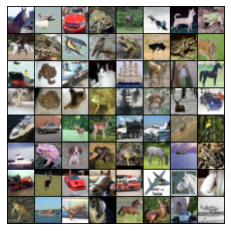

In [115]:
def showImage(images,epoch=-99, idx = -99):
    
    images = images.cpu().numpy()
    plt.imshow(np.transpose(images,axes = (1,2,0)))
    plt.axis('off')
    if not os.path.exists(path+"/e"+str(epoch)): 
        os.mkdir(path+'/e'+str(epoch))
    if epoch!=-99:
        plt.savefig( path+"/e"+str(epoch)+"/i" + str(idx) + ".png")

dataiter = iter(trainloader)
images,labels = next(dataiter)
print(images.size())
showImage(make_grid(images[0:64]))


In [116]:

class Generator(nn.Module):

    def __init__(self):
        super(Generator,self).__init__()

        #input 100*1*1
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(100,512,4,1,0,bias = False),
                                   nn.ReLU(True))

        #input 512*4*4
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512,256,4,2,1,bias = False),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(True))
        #input 256*8*8
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,1,bias = False),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(True))
        #input 128*16*16
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,1,bias = False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(True))
        #input 64*32*32
        self.layer5 = nn.Sequential(nn.ConvTranspose2d(64,3,4,2,1,bias = False),
                                   nn.Tanh())
        #output 3*64*64

        self.embedding = nn.Embedding(10,100)


    def forward(self,noise,label):

        label_embedding = self.embedding(label)
        x = torch.mul(noise,label_embedding)
        x = x.view(-1,100,1,1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x


In [117]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator,self).__init__()



        #input 3*64*64
        self.layer1 = nn.Sequential(nn.Conv2d(3,64,4,2,1,bias = False),
                                    nn.BatchNorm2d(64),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))

        #input 64*32*32
        self.layer2 = nn.Sequential(nn.Conv2d(64,128,4,2,1,bias = False),
                                    nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 128*16*16
        self.layer3 = nn.Sequential(nn.Conv2d(128,256,4,2,1,bias = False),
                                    nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 256*8*8
        self.layer4 = nn.Sequential(nn.Conv2d(256,512,4,2,1,bias = False),
                                    nn.BatchNorm2d(512),
                                   nn.LeakyReLU(0.2,True))
        #input 512*4*4
        self.validity_layer = nn.Sequential(nn.Conv2d(512,1,4,1,0,bias = False),
                                   nn.Sigmoid())

        self.label_layer = nn.Sequential(nn.Conv2d(512,11,4,1,0,bias = False),
                                   nn.LogSoftmax(dim = 1))

    def forward(self,x):
        plabels = torch.full((batch_size,),real_label , device = device)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        validity = self.validity_layer(x)
        plabel = self.label_layer(x)

        validity = validity.view(-1)
        plabel = plabel.view(-1,11)

        return validity,plabel

In [118]:
print(len(trainloader))

600


In [119]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

gen = Generator().to(device)
gen.apply(weights_init)

disc = Discriminator().to(device)
disc.apply(weights_init)

paramsG = list(gen.parameters())
print(len(paramsG))

paramsD = list(disc.parameters())
print(len(paramsD))

optimG = optim.Adam(gen.parameters(), 0.0002, betas = (0.5,0.999))
optimD = optim.Adam(disc.parameters(), 0.0002, betas = (0.5,0.999))

validity_loss = nn.BCELoss()

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)

12
14


[1/50] [599/600] D_x: 0.7868, D_G_z1: 0.5656, D_G_z2: 0.2227, G_loss: 6.7086, D_loss: 4.0659, D_label_loss: 7.7105: 100%|██████████| 600/600 [00:55<00:00, 10.75it/s]  
[2/50] [599/600] D_x: 0.7089, D_G_z1: 0.5827, D_G_z2: 0.3918, G_loss: 4.1807, D_loss: 4.2337, D_label_loss: 6.0034: 100%|██████████| 600/600 [00:57<00:00, 10.53it/s]
[3/50] [599/600] D_x: 0.6384, D_G_z1: 0.5359, D_G_z2: 0.5473, G_loss: 2.4691, D_loss: 4.2161, D_label_loss: 4.7000: 100%|██████████| 600/600 [00:57<00:00, 10.37it/s]
[4/50] [599/600] D_x: 0.5818, D_G_z1: 0.4977, D_G_z2: 0.5086, G_loss: 2.5286, D_loss: 4.1125, D_label_loss: 4.6211: 100%|██████████| 600/600 [00:59<00:00, 10.11it/s]
[5/50] [599/600] D_x: 0.6418, D_G_z1: 0.5119, D_G_z2: 0.5271, G_loss: 2.2183, D_loss: 3.9048, D_label_loss: 4.1538: 100%|██████████| 600/600 [01:00<00:00,  9.85it/s]
[6/50] [599/600] D_x: 0.6015, D_G_z1: 0.5326, D_G_z2: 0.4225, G_loss: 2.9812, D_loss: 4.2719, D_label_loss: 4.9770: 100%|██████████| 600/600 [01:02<00:00,  9.55it/s]
[7

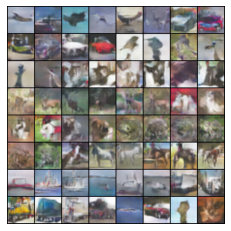

In [120]:
from tqdm import tqdm
epochs = 50
epoch_G_losses = []
epoch_D_losses = []
epoch_D_label_losses = []


for epoch in range(1, epochs + 1):
    # Wrap trainloader with tqdm for a progress bar
    trainloader_progress = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch}/{epochs}")
    epoch_G_loss_accum = 0.0
    epoch_D_loss_accum = 0.0
    epoch_D_label_loss_accum = 0.0
    num_batches = 0
    for idx, (images, labels) in trainloader_progress:
        batch_size = images.size(0)
        labels = labels.to(device)
        images = images.to(device)

        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]

        fake_class_labels = 10 * torch.ones((batch_size,), dtype=torch.long, device=device)

        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label

        # Training Discriminator
        optimD.zero_grad()

        # Real images
        validity_label = torch.full((batch_size,), real_label, device=device)
        pvalidity, plabels = disc(images)
        errD_real_val = validity_loss(pvalidity, validity_label)
        errD_real_label = F.nll_loss(plabels, labels)
        errD_real = errD_real_val + errD_real_label
        errD_real.backward()
        D_x = pvalidity.mean().item()

        # Fake images
        noise = torch.randn(batch_size, 100, device=device)
        sample_labels = torch.randint(0, 10, (batch_size,), device=device, dtype=torch.long)
        fakes = gen(noise, sample_labels)
        validity_label.fill_(fake_label)
        pvalidity, plabels = disc(fakes.detach())
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        errD_fake = errD_fake_val + errD_fake_label
        errD_fake.backward()
        D_G_z1 = pvalidity.mean().item()

        errD = errD_real + errD_fake
        optimD.step()
        
        # Training Generator
        optimG.zero_grad()
        noise = torch.randn(batch_size, 100, device=device)
        sample_labels = torch.randint(0, 10, (batch_size,), device=device, dtype=torch.long)
        validity_label.fill_(1)
        fakes = gen(noise, sample_labels)
        pvalidity, plabels = disc(fakes)
        errG_val = validity_loss(pvalidity, validity_label)
        errG_label = F.nll_loss(plabels, sample_labels)
        errG = errG_val + errG_label
        errG.backward()
        D_G_z2 = pvalidity.mean().item()
        optimG.step()
        
        epoch_G_loss_accum += errG.item()
        epoch_D_loss_accum += errD.item()
        epoch_D_label_loss_accum += (errD_real_label.item() + errD_fake_label.item())
        num_batches += 1


        # Update progress bar description
        trainloader_progress.set_description(
            f"[{epoch}/{epochs}] [{idx}/{len(trainloader)}] D_x: {D_x:.4f}, D_G_z1: {D_G_z1:.4f}, D_G_z2: {D_G_z2:.4f}, "
            f"G_loss: {errG:.4f}, D_loss: {errD:.4f}, D_label_loss: {errD_real_label + errD_fake_label + errG_label:.4f}"
        )

        if idx % 100 == 0:
            noise = torch.randn(64, 100, device=device)
            # Generate labels 0 to 9, each repeated 6 times to make 60 labels
            # Then, add 4 more labels to make a total of 64
            labels = torch.cat((torch.arange(0, 10, device=device).repeat_interleave(6), torch.arange(0, 4, device=device)), 0)
            gen_images = gen(noise, labels).detach()
            grid = torchvision.utils.make_grid(gen_images, nrow=8,normalize=True)
            showImage(make_grid(grid), epoch, idx)
    epoch_G_losses.append(epoch_G_loss_accum / num_batches)
    epoch_D_losses.append(epoch_D_loss_accum / num_batches)
    epoch_D_label_losses.append(epoch_D_label_loss_accum / num_batches)
    
torch.save(gen.state_dict(), 'gen.pth')
torch.save(disc.state_dict(), 'disc.pth')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


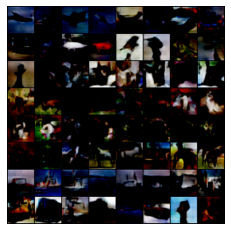

In [121]:
    gen_images = gen_images*2-1 
   
    grid = torchvision.utils.make_grid(gen_images, nrow=8)
    showImage(make_grid(grid), epoch, idx)

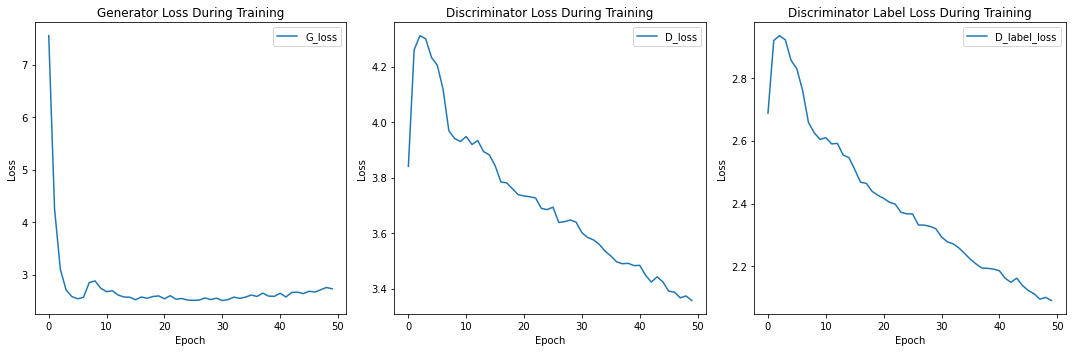

In [122]:
plt.figure(figsize=(15,5))
# Plot Generator loss
plt.subplot(1, 3, 1)
plt.title("Generator Loss During Training")
plt.plot(epoch_G_losses, label="G_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Discriminator loss
plt.subplot(1, 3, 2)
plt.title("Discriminator Loss During Training")
plt.plot(epoch_D_losses, label="D_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Discriminator label loss
plt.subplot(1, 3, 3)
plt.title("Discriminator Label Loss During Training")
plt.plot(epoch_D_label_losses, label="D_label_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()
plt.show()

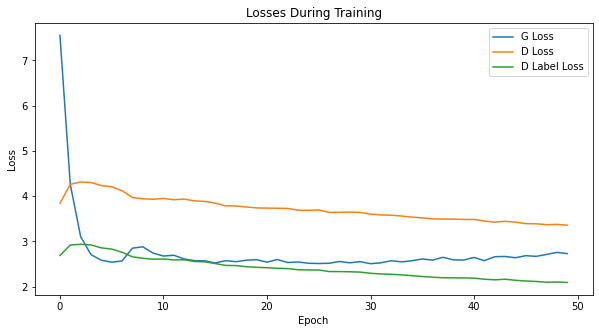

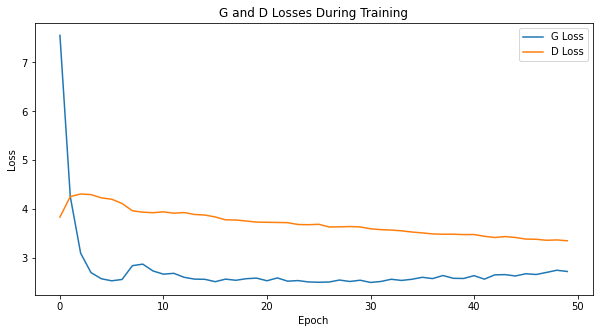

In [123]:
plt.figure(figsize=(10,5))
plt.title("Losses During Training")
plt.plot(epoch_G_losses, label="G Loss")
plt.plot(epoch_D_losses, label="D Loss")
plt.plot(epoch_D_label_losses, label="D Label Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot only G_loss and D_loss
plt.figure(figsize=(10,5))
plt.title("G and D Losses During Training")
plt.plot(epoch_G_losses, label="G Loss")
plt.plot(epoch_D_losses, label="D Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()